In [157]:
import pandas as pd 
import os

In [158]:
#validacion-auc:0.827302	train-auc:0.850227
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import auc, roc_curve


def plot_roc_curve(y_true, y_score, filepath=None, line_width=2, width=12,
                   height=10, title=None, colors=("#FF0000", "#000000")):
    """
    Saves a ROC curve in a file or shows it on screen.
    :param y_true: actual values of the response (list|np.array)
    :param y_score: predicted scores (list|np.array)
    :param filepath: if given, the ROC curve is saved in the desired filepath. It should point to a png file in an
    existing directory. If not specified, the curve is only shown (str)
    :param line_width: number indicating line width (float)
    :param width: number indicating the width of saved plot (float)
    :param height: number indicating the height of saved plot (float)
    :param title: if given, title to add to the top side of the plot (str)
    :param colors: color specification for ROC curve and diagonal respectively (tuple of str)
    :return: None
    """
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_score)
    gini = auc(fpr, tpr) * 2 - 1

    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(width, height))
    major_ticks = np.arange(0, 1.1, 0.1)
    minor_ticks = np.arange(0.05, 1, 0.1)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which="both", axis="both")
    ax.grid(which="minor", alpha=0.2)
    ax.grid(which="major", alpha=0.5)
    ax.tick_params(which="major", direction="out", length=5)
    plt.plot(fpr, tpr, color=colors[0], lw=line_width,
                   label="ROC curve (gini = {:.2f})".format(gini))
    plt.plot([0, 1], [0, 1], color=colors[1], lw=line_width, linestyle='--')
    plt.xlim([-0.001, 1.001])
    plt.ylim([-0.001, 1.001])
    plt.xlabel("False positive rate", fontsize=15)
    plt.ylabel("True positive rate", fontsize=15)
    if title:
        plt.title(title, fontsize=30, loc="left")
    plt.legend(loc="lower right", frameon=True, fontsize="xx-large",
                     fancybox=True)
    plt.tight_layout()
    if filepath:
        plt.savefig(filepath, dpi=200)
        plt.close()
    else:
        plt.show()

In [159]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Brewing_Datacup/notebooks')

In [160]:
### cargar data intermedia que contiene todos los campos 4 bases anteriores
df_intermediate = pd.read_pickle('../data/df_feature_engineering.pkl')

In [161]:
### cargar data de testeo
df_test = pd.read_csv('../data/test.csv')
df_test['Cliente_Marca_Cupo'] = df_test['Cliente'].astype('str')+df_test['Marca'].astype('str')+df_test['Cupo'].astype('str')
df_test.set_index('Cliente_Marca_Cupo', inplace=True)

## Construcción del Target

In [162]:
df_intermediate['NroPromocionesRatio'].describe()

count    34551.000000
mean         0.040946
std          0.093638
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: NroPromocionesRatio, dtype: float64

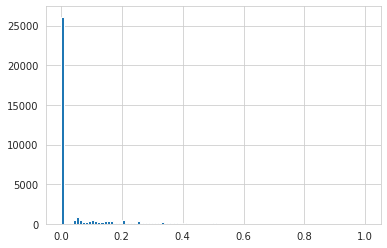

In [163]:
df_intermediate['NroPromocionesRatio'].hist(bins = 100)

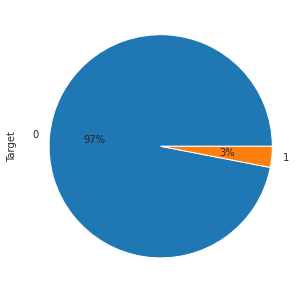

In [164]:
df_intermediate['Target'] = df_intermediate['NroPromocionesRatio'].apply(lambda x: 1 if x > 0.3 else 0) ## 0.25 , 0.3 0.82497559261953
df_intermediate['Target'].value_counts().plot(kind='pie', autopct = "%1.0f%%", figsize=(5, 10));

In [8]:
# etiqueta = [0, 1, 2, 3]
# df_intermediate['Class'] = pd.cut(df_intermediate['NroPromocionesRatio'], bins=4, labels=etiqueta)
# df_intermediate['Class'].value_counts()

In [9]:
# df_intermediate['Target'] = df_intermediate['Class'].apply(lambda x: 1 if x >0 else 0)
# df_intermediate.drop(['Class'], axis=1, inplace=True)
# df_intermediate['Target'].value_counts().plot(kind='pie', autopct = "%1.0f%%", figsize=(5, 10));

In [165]:
def get_mes(n,arr):
  cont = 0
  for i in arr:
    if n == i:
      cont=cont+1
  return cont
for i in range(1,13,1):
  df_intermediate["mes_"+str(i)] = df_intermediate["Mes"].apply(lambda x: get_mes(i, x))
for i in range(1,3,1):
  df_intermediate["ClaseEnvases_"+str(i)] = df_intermediate["ClaseEnvase"].apply(lambda x: get_mes(i, x)) ## ojo
for i in range(1,5,1):
  df_intermediate["SegmentoPrecio_"+str(i)] = df_intermediate["SegmentoPrecio"].apply(lambda x: get_mes(i, x))

def get_list_marca(x):
  dict_ = {40:0, 39:0, 29:0}
  for i in x:
    if i in [40,39,29]:
      dict_[i] +=1
  return dict_
aux_list_marca = pd.DataFrame(list(df_intermediate['ListMarca'].apply(lambda x: get_list_marca(x))), index=df_intermediate.index)
aux_list_marca.columns = ['Marca_Freq_40', 'Marca_Freq_39', 'Marca_Freq_29']

def get_list_cupo(x):
  dict_ = {16:0, 20:0, 9:0}
  for i in x:
    if i in [16,20,9]:
      dict_[i] +=1
  return dict_
aux_list_cupo = pd.DataFrame(list(df_intermediate['ListCupo'].apply(lambda x: get_list_cupo(x))), index=df_intermediate.index)
aux_list_cupo.columns = ['Cupo_Freq_16', 'Cupo_Freq_20', 'Cupo_Freq_9']

In [166]:
df_intermediate = pd.concat([df_intermediate,aux_list_marca, aux_list_cupo], axis=1)

In [12]:
# TipoPoblacion
# EF

In [167]:
import datetime as dt
df_intermediate['Annios_Desde_FechaAltaCliente'] = round(df_intermediate['FechaAltaCliente'].apply(lambda x: (dt.datetime.now() - dt.datetime.strptime(x, '%Y-%m-%d')).days)/365, 0)
df_intermediate['Meses_Desde_FechaAltaCliente'] = round(df_intermediate['FechaAltaCliente'].apply(lambda x: (dt.datetime.now() - dt.datetime.strptime(x, '%Y-%m-%d')).days)/30, 0)
df_intermediate['Dias_Desde_FechaAltaCliente'] = df_intermediate['FechaAltaCliente'].apply(lambda x: (dt.datetime.now() - dt.datetime.strptime(x, '%Y-%m-%d')).days)

In [168]:
!pip install -q category_encoders
import category_encoders as ce
import warnings as w
w.filterwarnings('ignore')
encoder = ce.BinaryEncoder(cols=['Gerencia','SubCanal'])
X_binenc = encoder.fit_transform(df_intermediate[['Gerencia', 'SubCanal']])
X_binenc.head()

,Gerencia_0,Gerencia_1,Gerencia_2,Gerencia_3,Gerencia_4,Gerencia_5,Gerencia_6,SubCanal_0,SubCanal_1,SubCanal_2,SubCanal_3,SubCanal_4,SubCanal_5
Cliente_Marca_Cupo,,,,,,,,,,,,,
3213299,0,0,0,0,0,0,1,0,0,0,0,0,1
3795299,0,0,0,0,0,1,0,0,0,0,0,1,0
11816299,0,0,0,0,0,1,1,0,0,0,0,1,1
84444016,0,0,0,0,1,0,0,0,0,0,1,0,0
84884016,0,0,0,0,0,1,0,0,0,0,1,0,1


In [169]:
df_marca_dummies = pd.get_dummies(df_intermediate['Marca'],prefix='Marca')
df_cupo_dummies = pd.get_dummies(df_intermediate['Cupo'],prefix='Cupo')
df_region_dummies = pd.get_dummies(df_intermediate['Region'],prefix='Region')
df_estrato_dummies = pd.get_dummies(df_intermediate['Estrato'],prefix='Estrato')
df_intermediate = pd.concat([df_intermediate, X_binenc,df_marca_dummies, df_cupo_dummies, df_region_dummies, df_estrato_dummies], axis=1)

In [170]:
df_intermediate

,Cliente,Marca,Cupo,CodigoDC,Is_Executed,Fecha_Desde,Fecha_Hasta,Duracion_Promocion,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr,Hl,Dcto,Año,Mes,ClaseEnvase,SegmentoPrecio,ListMarca,ListCupo,NroPromociones,NroPromocionesConsumidas,NroPromocionesRatio,Target,Duracion_Promocion_Max,Duracion_Promocion_Mean,Nr_Total,Nr_Promedio,Nr_Std,Nro_Compra,Hl_Total,Hl_Promedio,Dcto_Total,Dcto_Promedio,Mes_Moda,ClaseEnvase_Moda,...,SegmentoPrecio_4,Marca_Freq_40,Marca_Freq_39,Marca_Freq_29,Cupo_Freq_16,Cupo_Freq_20,Cupo_Freq_9,Annios_Desde_FechaAltaCliente,Meses_Desde_FechaAltaCliente,Dias_Desde_FechaAltaCliente,Gerencia_0,Gerencia_1,Gerencia_2,Gerencia_3,Gerencia_4,Gerencia_5,Gerencia_6,SubCanal_0,SubCanal_1,SubCanal_2,SubCanal_3,SubCanal_4,SubCanal_5,Marca_29,Marca_39,Marca_40,Cupo_9,Cupo_16,Cupo_20,Region_1,Region_2,Region_3,Region_4,Region_5,Estrato_1,Estrato_2,Estrato_3,Estrato_4,Estrato_5,Estrato_6
Cliente_Marca_Cupo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3213299,3213,29,9,"[297601, 354404, 619037, 619621, 542054]","[0, 0, 0, 0, 0]","[2018-08-06 00:00:00, 2018-09-03 00:00:00, 201...","[2018-08-30 00:00:00, 2018-09-27 00:00:00, 201...","[24, 24, 5, 3, 3]",2010-03-29,3,8,15,2,3,1,"[29082.62, 16184.87, 76800.02, 28110.53, 9076....","[0.09, 0.09, 0.25, 0.09, 0.02, 0.03, 0.03, 0.0...","[0.0, 0.0, 0.0, -1333.83, 0.0, 0.0, 0.0, -621....","[2018, 2018, 2018, 2018, 2018, 2018, 2018, 201...","[2, 3, 3, 3, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 7, ...","[2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, ...","[1, 2, 1, 3, 1, 3, 1, 3, 3, 1, 1, 2, 1, 1, 1, ...","[32, 44, 32, 23, 28, 23, 2, 23, 23, 2, 40, 37,...","[17, 29, 17, 16, 25, 26, 26, 26, 16, 26, 22, 3...",5,0,0.000000,0,24,11.800000,8245890.31,29555.162401,35056.338822,279,25.70,0.092115,-343961.24,-1232.835986,7,1,...,27,40,0,13,83,0,2,11.0,130.0,3898,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
3795299,3795,29,9,"[297601, 354404, 542055, 619684, 644816, 61843...","[0, 0, 0, 0, 0, 0, 0, 0, 0]","[2018-08-06 00:00:00, 2018-09-03 00:00:00, 201...","[2018-08-30 00:00:00, 2018-09-27 00:00:00, 201...","[24, 24, 3, 3, 7, 5, 17, 9, 9]",2010-04-26,3,10,6,2,3,1,"[84189.6, 115610.44, 106536.01, 19009.21, 9504...","[0.26, 0.36, 0.13, 0.05, 0.03, 0.05, 0.03, 0.6...","[0.0, 0.0, -9264.0, 0.0, 0.0, -1079.72, -754.7...","[2018, 2018, 2018, 2018, 2018, 2018, 2018, 201...","[1, 1, 2, 3, 3, 4, 4, 5, 6, 6, 7, 9, 12, 1, 2,...","[1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, ...","[1, 1, 4, 3, 3, 3, 3, 1, 4, 1, 1, 1, 3, 4, 4, ...","[40, 40, 30, 23, 26, 23, 23, 40, 17, 2, 6, 2, ...","[22, 16, 18, 26, 26, 26, 16, 22, 12, 16, 16, 1...",9,0,0.000000,0,24,11.222222,8845590.24,61004.070621,54801.536760,145,25.16,0.173517,-516194.14,-3559.959586,6,1,...,34,31,0,9,46,0,4,11.0,129.0,3870,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
11816299,11816,29,9,"[297601, 354404, 646169, 659921, 660481, 542055]","[1, 0, 0, 0, 0, 0]","[2018-08-06 00:00:00, 2018-09-03 00:00:00, 201...","[2018-08-30 00:00:00, 2018-09-27 00:00:00, 201...","[24, 24, 7, 9, 9, 3]",2017-10-01,3,7,12,2,3,1,"[91605.99, 48655.49, 64183.96, 39308.15, 49778...","[0.33, 0.15, 0.21, 0.12, 0.07, 0.24, 0.09, 1.6...","[0.0, 0.0, 0.0, 0.0, -4328.55, 0.0, 0.0, -2276...","[2018, 2018, 2018, 2018, 2018, 2018, 2018, 201...","[1, 1, 2, 2, 3, 4, 5, 5, 6, 6, 6, 7, 7, 7, 7, ...","[2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, ...","[1, 3, 1, 3, 4, 3, 1, 1, 4, 1, 1, 1, 1, 1, 3, ...","[2, 46, 6, 26, 31, 23, 32, 40, 17, 6, 40, 4, 7...","[16, 16, 16, 16, 8, 16, 17, 16, 12, 16, 16, 16...",6,1,0.166667,0,24,12.666667,33937360.15,190659.326685,393521.543944,178,112.18,0.630225,-1970571.13,-11070.624326,2,2,...,16,21,0,3,130,0,1,3.0,38.0,1155,0,0,0,0,0,1,1,0,0,0,0,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
84444016,8444,40,16,"[298856, 355104, 357820, 360816, 354320, 40554...","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[2018-08-12 00:00:00, 2018-09-05 00:00:00, 201...","[2018-08-19 00:00:00, 2018-0

## Entrenamiento

In [171]:
# delete variables
var_delete = ['CodigoDC', 'Is_Executed', 'Fecha_Desde', 'Fecha_Hasta', 'Duracion_Promocion', 'FechaAltaCliente', 'Nr', 'Hl', 'Dcto', 'Año', 'Mes', 'ClaseEnvase', 'SegmentoPrecio', 'ListMarca', 'ListCupo']
df_intermediate.drop(var_delete, axis=1, inplace=True)

In [172]:
df_intermediate.columns, df_intermediate.shape

(Index(['Cliente', 'Marca', 'Cupo', 'Region', 'Gerencia', 'SubCanal',
        'TipoPoblacion', 'Estrato', 'EF', 'NroPromociones',
        'NroPromocionesConsumidas', 'NroPromocionesRatio', 'Target',
        'Duracion_Promocion_Max', 'Duracion_Promocion_Mean', 'Nr_Total',
        'Nr_Promedio', 'Nr_Std', 'Nro_Compra', 'Hl_Total', 'Hl_Promedio',
        'Dcto_Total', 'Dcto_Promedio', 'Mes_Moda', 'ClaseEnvase_Moda',
        'SegmentoPrecio_Moda', 'Marca_Moda', 'Cupo_Moda', 'mes_1', 'mes_2',
        'mes_3', 'mes_4', 'mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9', 'mes_10',
        'mes_11', 'mes_12', 'ClaseEnvases_1', 'ClaseEnvases_2',
        'SegmentoPrecio_1', 'SegmentoPrecio_2', 'SegmentoPrecio_3',
        'SegmentoPrecio_4', 'Marca_Freq_40', 'Marca_Freq_39', 'Marca_Freq_29',
        'Cupo_Freq_16', 'Cupo_Freq_20', 'Cupo_Freq_9',
        'Annios_Desde_FechaAltaCliente', 'Meses_Desde_FechaAltaCliente',
        'Dias_Desde_FechaAltaCliente', 'Gerencia_0', 'Gerencia_1', 'Gerencia_2',
      

In [272]:
var_categ = [
 'Marca', 'Cupo', 'Region', 'Gerencia', 'SubCanal', 'Estrato',
 'Cliente', 'TipoPoblacion', 'EF', 'Mes_Moda', 'ClaseEnvase_Moda', 'SegmentoPrecio_Moda', 'Marca_Moda', 'Cupo_Moda', 'mes_1', 'mes_2', 'mes_3',
 'mes_4', 'mes_5', 'mes_6', 'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12', 'ClaseEnvases_1', 
 'ClaseEnvases_2','SegmentoPrecio_1', 'SegmentoPrecio_2', 'SegmentoPrecio_3', 'SegmentoPrecio_4',
#  'Gerencia_0', 'Gerencia_1', 'Gerencia_2', 'Gerencia_3', 'Gerencia_4', 'Gerencia_5', 'Gerencia_6', 'SubCanal_0',
#  'SubCanal_1', 'SubCanal_2', 'SubCanal_3', 'SubCanal_4', 'SubCanal_5',
#  'Marca_29', 'Marca_39', 'Marca_40', 'Cupo_9', 'Cupo_16', 'Cupo_20',
#  'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Estrato_1',
#  'Estrato_2', 'Estrato_3', 'Estrato_4', 'Estrato_5', 'Estrato_6'
]

In [273]:
var_cuanti = [
  'NroPromociones',
  'Duracion_Promocion_Max',
  'Duracion_Promocion_Mean',
  'Nr_Total',
  'Nr_Promedio', 
  'Nr_Std',
  'Nro_Compra',
  'Hl_Total',
  'Hl_Promedio',
  'Dcto_Total',
  'Dcto_Promedio',
  'Marca_Freq_40', 
  'Marca_Freq_39', 
  'Marca_Freq_29',
  'Cupo_Freq_16',
  'Cupo_Freq_20',
  'Cupo_Freq_9',
  'Annios_Desde_FechaAltaCliente',
  'Meses_Desde_FechaAltaCliente',
  'Dias_Desde_FechaAltaCliente'
]
 ### quitando  # 'Duracion_Promocion_Max', 0.81899508660188

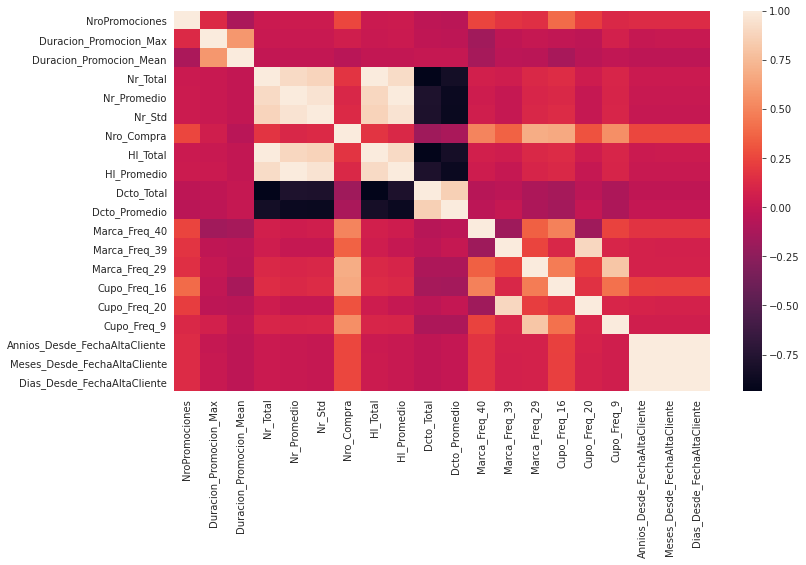

In [274]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 7))
sns.heatmap(df_intermediate[var_cuanti].corr());

In [275]:
var_total = var_cuanti + var_categ
var_total

['NroPromociones',
 'Duracion_Promocion_Max',
 'Duracion_Promocion_Mean',
 'Nr_Total',
 'Nr_Promedio',
 'Nr_Std',
 'Nro_Compra',
 'Hl_Total',
 'Hl_Promedio',
 'Dcto_Total',
 'Dcto_Promedio',
 'Marca_Freq_40',
 'Marca_Freq_39',
 'Marca_Freq_29',
 'Cupo_Freq_16',
 'Cupo_Freq_20',
 'Cupo_Freq_9',
 'Annios_Desde_FechaAltaCliente',
 'Meses_Desde_FechaAltaCliente',
 'Dias_Desde_FechaAltaCliente',
 'Marca',
 'Cupo',
 'Region',
 'Gerencia',
 'SubCanal',
 'Estrato',
 'Cliente',
 'TipoPoblacion',
 'EF',
 'Mes_Moda',
 'ClaseEnvase_Moda',
 'SegmentoPrecio_Moda',
 'Marca_Moda',
 'Cupo_Moda',
 'mes_1',
 'mes_2',
 'mes_3',
 'mes_4',
 'mes_5',
 'mes_6',
 'mes_7',
 'mes_8',
 'mes_9',
 'mes_10',
 'mes_11',
 'mes_12',
 'ClaseEnvases_1',
 'ClaseEnvases_2',
 'SegmentoPrecio_1',
 'SegmentoPrecio_2',
 'SegmentoPrecio_3',
 'SegmentoPrecio_4']

In [23]:
#Nr_Total  mucha correlacion Hr_Total y poca con Nr_Std, r_Promedio y Hl_Promedio
#Nr_Std mucha correlacion Nr_Promedio y Hl_Promedio y poco con  Nr_Total y Hr_Total
#Dcto_Total  mucha correlacion Dcto_Promedio
#Duracion_Promocion_Max poca correlacion con Duracion_Promocion_Mean

In [258]:
var_total = ['Cupo',
 'mes_7',
 'mes_5',
 'SubCanal',
 'mes_10',
 'mes_1',
 'Nro_Compra',
 'mes_3',
 'Region',
 'mes_11',
 'Cupo_Freq_20',
 'Marca_Freq_39',
 'mes_9',
 'mes_6',
 'mes_4',
 'Nr_Total',
 'Mes_Moda',
 'Marca',
 'ClaseEnvases_2',
 'mes_8',
 'Hl_Promedio',
 'mes_12',
 'SegmentoPrecio_1',
 'Hl_Total',
 'Nr_Promedio',
 'SegmentoPrecio_4',
 'Cupo_Freq_9',
 'Cliente',
 'Dias_Desde_FechaAltaCliente',
 'ClaseEnvases_1',
 'Nr_Std',
 'SegmentoPrecio_2',
 'Gerencia',
 'SegmentoPrecio_3',
 'Dcto_Total',
 'Dcto_Promedio',
 'Cupo_Freq_16',
 'Marca_Freq_40',
 'NroPromociones',
 'Duracion_Promocion_Mean']

 ### pimero quintando Duracion_Promocion_Max 0.8186865593861
 ### pimero quintando Duracion_Promocion_Mean 0.8175865593861
 ### sin Duracion_Promocion_Max y Duracion_Promocion_Mean 0.81739340262825
 ### quitando 'Dcto_Total',  0.81727169005689
 ### quitando 'Dcto_Promedio' 0.81770979241323
 ### quitando #  'Nr_Std',  0.81724818097496
 ### quitando #  'Nr_Promedio', 0.81730612811003
 ### quitando #  'Hl_Promedio', 0.81746558101359
 ### quitand #  'Hl_Total', 0.81725156187972
 ### #  'Nr_Total', 0.81724802372357

In [276]:
x = df_intermediate[var_total].copy()
y = df_intermediate['Target']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42, stratify = y )
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((27640, 52), (6911, 52), (27640,), (6911,))

In [277]:
import lightgbm as lgb
train_data=lgb.Dataset(x_train,label = y_train)
### definir los parámetros del modelo
param = {'num_leaves':50,'objective':'binary','max_depth':9,'learning_rate':0.01,'max_bin':200} ## 100 ###6, ##200
param['metric'] =['auc','binary_logloss']
num_round=500 ##1000
### entrenar el modelo Ligh GBM
clf=lgb.train(param,train_data,num_round)

In [332]:
import numpy as np
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
# kf.get_n_splits(x_train)
kf.get_n_splits(x)

5

In [333]:
from lightgbm import LGBMClassifier

test_probs = []
train_probs = []
# for mes in x_train.codmes.unique():
# for n, (train_index, test_index) in enumerate(kf.split(x_train)):
for n, (train_index, test_index) in enumerate(kf.split(x)):
    # Xt = x_train.iloc[train_index]
    # yt = y_train.iloc[train_index]
    Xt = x.iloc[train_index]
    yt = y.iloc[train_index]
    # Xv = x_train.iloc[test_index]
    # yv = y_train.iloc[test_index]
    Xv = x.iloc[test_index]
    yv = y.iloc[test_index]

    learner = LGBMClassifier(n_estimators=1000, max_depth=9)
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=50)
    # test_probs.append(pd.Series(learner.predict_proba(x_test)[:, -1],
                                # index=x_test.index, name="fold_" + str(n)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1],
                                index=Xv.index, name="probs"))

# test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)

Training until validation scores don't improve for 10 rounds.
[50]	training's auc: 0.996042	training's binary_logloss: 0.0328772	valid_1's auc: 0.941559	valid_1's binary_logloss: 0.136365
Early stopping, best iteration is:
[43]	training's auc: 0.994356	training's binary_logloss: 0.0357554	valid_1's auc: 0.941439	valid_1's binary_logloss: 0.136177
Training until validation scores don't improve for 10 rounds.
[50]	training's auc: 0.994862	training's binary_logloss: 0.0394388	valid_1's auc: 0.951503	valid_1's binary_logloss: 0.0957433
Early stopping, best iteration is:
[57]	training's auc: 0.995839	training's binary_logloss: 0.0371131	valid_1's auc: 0.952259	valid_1's binary_logloss: 0.0953003
Training until validation scores don't improve for 10 rounds.
[50]	training's auc: 0.992038	training's binary_logloss: 0.0493646	valid_1's auc: 0.957874	valid_1's binary_logloss: 0.0515781
Early stopping, best iteration is:
[52]	training's auc: 0.992538	training's binary_logloss: 0.0484887	valid_1's

In [27]:
# from lightgbm import LGBMClassifier
# clf = LGBMClassifier(n_estimators=10000) # max_depth=6,num_leaves=200## # 6,9,11,13, 14 class_weight='balanced' learning_rate=0.01
# clf.fit(x_train, y_train,  early_stopping_rounds=10, eval_metric="auc",
#             eval_set=[(x_train, y_train), (x_test, y_test)], verbose=50)

In [278]:
# Find optimal probability threshold
pred = clf.predict(x_test)
# pred = clf.predict_proba(x_test)[:,-1]
pred

array([0.00043524, 0.00230691, 0.00202181, ..., 0.0510905 , 0.00393344,
       0.00058897])

In [279]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred)

0.9454956971596278

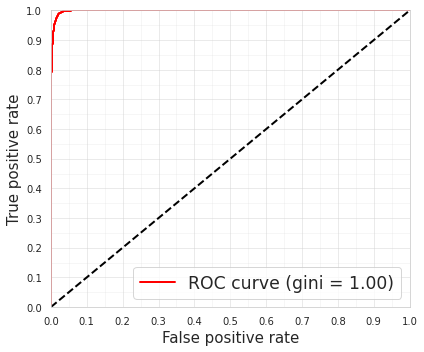

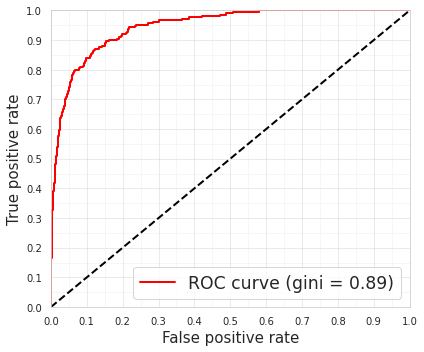

In [280]:
##ROC en el train
pred_train=clf.predict(x_train)
plot_roc_curve(y_train,pred_train,width=6,height=5)
##ROC en el test
pred_test=clf.predict(x_test)
plot_roc_curve(y_test,pred_test,width=6,height=5)

In [281]:
from sklearn.metrics import classification_report
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6701
           1       0.75      0.23      0.36       210

    accuracy                           0.97      6911
   macro avg       0.87      0.62      0.67      6911
weighted avg       0.97      0.97      0.97      6911



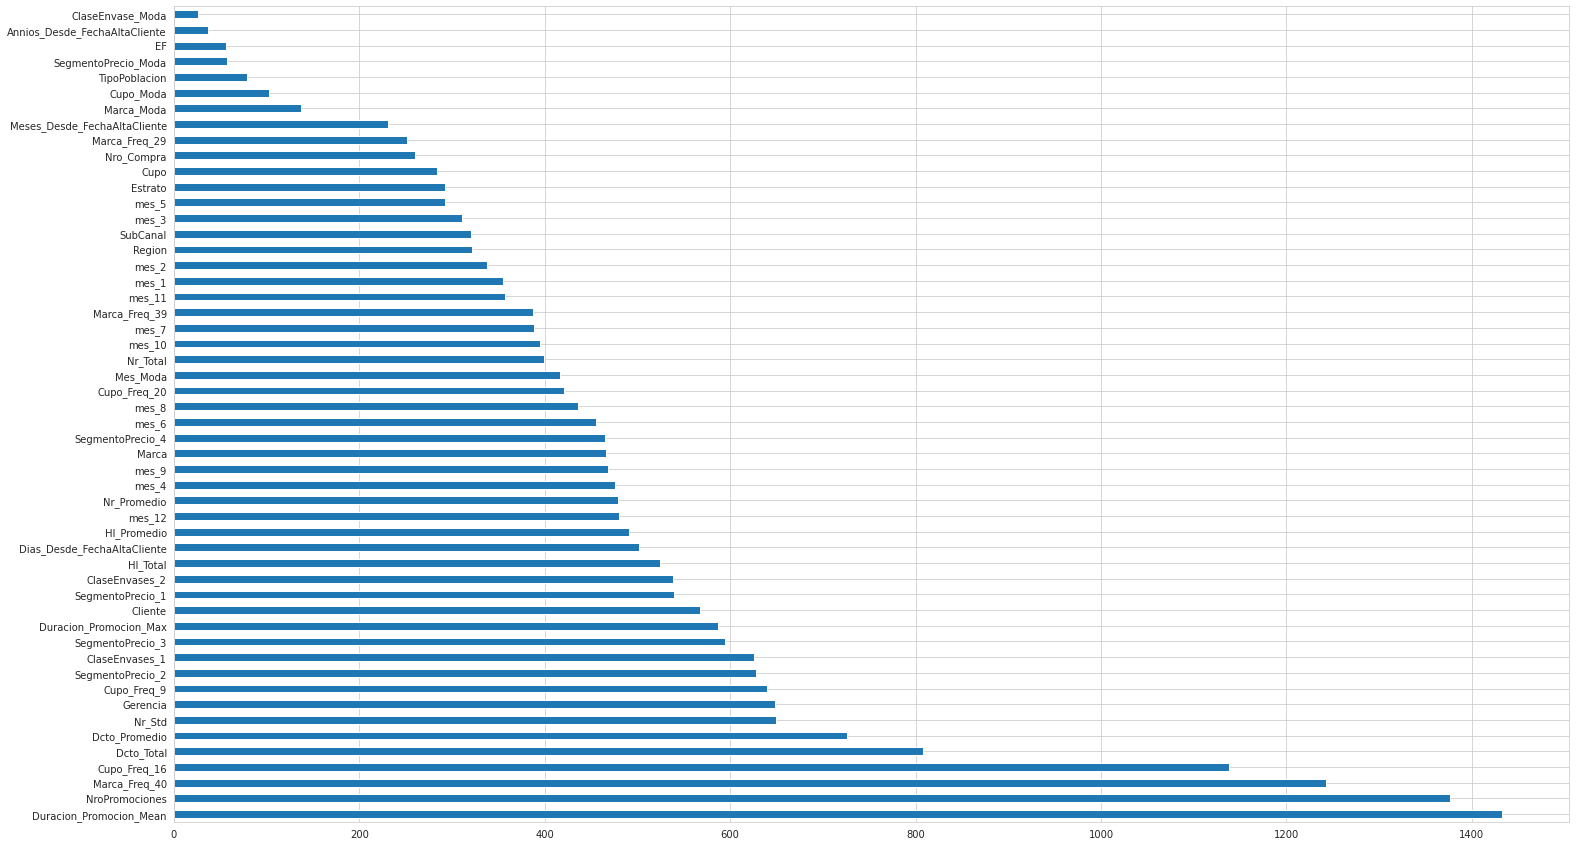

In [282]:
feat_importances = pd.Series(clf.feature_importance(), index=x.columns)
# feat_importances = pd.Series(clf.feature_importances_, index=x.columns)
feat_importances.nlargest(52).plot(kind='barh', figsize=(25, 15))

In [470]:
#NroPromociones, Duracion_Promocion_Mean, Marca_freq_40, Cubo_Freq_16, Duracion_Promocion_Max, Dcto_Promedio, Dcto_Total, Gerencia, Marca

In [283]:
feat_importances.sort_values().tail(40).index.tolist()

['mes_5',
 'mes_3',
 'SubCanal',
 'Region',
 'mes_2',
 'mes_1',
 'mes_11',
 'Marca_Freq_39',
 'mes_7',
 'mes_10',
 'Nr_Total',
 'Mes_Moda',
 'Cupo_Freq_20',
 'mes_8',
 'mes_6',
 'SegmentoPrecio_4',
 'Marca',
 'mes_9',
 'mes_4',
 'Nr_Promedio',
 'mes_12',
 'Hl_Promedio',
 'Dias_Desde_FechaAltaCliente',
 'Hl_Total',
 'ClaseEnvases_2',
 'SegmentoPrecio_1',
 'Cliente',
 'Duracion_Promocion_Max',
 'SegmentoPrecio_3',
 'ClaseEnvases_1',
 'SegmentoPrecio_2',
 'Cupo_Freq_9',
 'Gerencia',
 'Nr_Std',
 'Dcto_Promedio',
 'Dcto_Total',
 'Cupo_Freq_16',
 'Marca_Freq_40',
 'NroPromociones',
 'Duracion_Promocion_Mean']

## Output

In [336]:
# pred_total = pd.concat([train_probs,test_probs] ,axis = 0)
# pred_ = pred_total.loc[df_test.index]
pred_ = train_probs.loc[df_test.index]
df_test['Ejecuto_Promo'] = pred_
df_test

,Cliente,Marca,Cupo,Ejecuto_Promo
Cliente_Marca_Cupo,,,,
104016,10,40,16,0.006369
17299,17,29,9,0.009728
37299,37,29,9,0.003042
46299,46,29,9,0.020765
48299,48,29,9,0.002593
...,...,...,...,...
150534016,15053,40,16,0.052713
150544016,15054,40,16,0.143430
150564016,15056,40,16,0.149591


In [326]:
# pred_ = clf.predict(x.loc[df_test.index])
# # pred_ = clf.predict_proba(x.loc[df_test.index])[:,-1]
# df_test['Ejecuto_Promo'] = pred_
# df_test

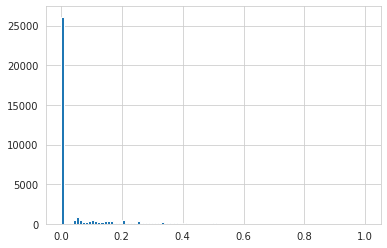

In [337]:
df_intermediate['NroPromocionesRatio'].hist(bins=100)

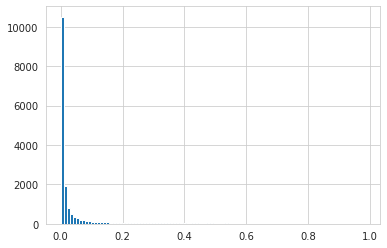

In [338]:
df_test['Ejecuto_Promo'].hist(bins=100)

In [339]:
df_test.to_csv('../results/df_pred_v129.csv', sep=',', encoding='utf 8', index = False)

In [340]:
df_test_ = pd.read_csv('../results/df_pred_v129.csv', sep=',')
df_test_

,Cliente,Marca,Cupo,Ejecuto_Promo
0,10,40,16,0.006369
1,17,29,9,0.009728
2,37,29,9,0.003042
3,46,29,9,0.020765
4,48,29,9,0.002593
...,...,...,...,...
16865,15053,40,16,0.052713
16866,15054,40,16,0.143430
16867,15056,40,16,0.149591
16868,15057,29,9,0.011245


In [477]:
### Cross Validation

## Regressor

In [478]:
# NroPromocionesConsumidas	NroPromocionesRatio

In [479]:
x = df_intermediate[var_total].copy()
# y = df_intermediate['NroPromocionesConsumidas']
y = df_intermediate['NroPromocionesConsumidas']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((27640, 51), (6911, 51), (27640,), (6911,))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
learner = RandomForestRegressor(max_depth=7, n_estimators=300, random_state=42)
learner.fit(x_train, y_train)

In [ ]:
# from lightgbm import LGBMRegressor
# learner = LGBMRegressor(n_estimators=1000, max_depth=6, class_weight='balanced', learning_rate=0.01, random_state=42)
# learner.fit(x_train, y_train,  early_stopping_rounds=10, eval_metric="mae",
#                 eval_set=[(x_train, y_train), (x_test, y_test)], verbose=50)

In [ ]:
import math
import numpy as np
pred_regressor = learner.predict(x.loc[df_test.index])
pred_regressor = (pred_regressor-min(pred_regressor))/(max(pred_regressor)-min(pred_regressor))
pd.Series(pred_regressor).describe()

In [ ]:
pred_clasiffier = clf.predict(x.loc[df_test.index])

In [ ]:
pred_final = pred_clasiffier*0.9 + pred_regressor*0.1
pd.Series(pred_final).describe()

In [ ]:
pd.Series(pred_final).hist(bins = 100)

In [ ]:
df_test['Ejecuto_Promo'] = pred_regressor
df_test

In [ ]:
df_test.to_csv('../results/df_pred_v79.csv', sep=',', encoding='utf 8', index = False)

## Balanceo Data

In [ ]:
# # Oversample and plot imbalanced dataset with SMOTE
# ### crear mustras sinteticas de forma aleatoria para la clases minoritaria
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import SMOTE
# from matplotlib import pyplot
# from numpy import where
# # define dataset
# # summarize class distribution
# counter = Counter(y_train)
# print(counter)
# # transform the dataset
# oversample = SMOTE()
# x_train_, y_train_ = oversample.fit_resample(x_train, y_train)
# # summarize the new class distribution
# counter = Counter(y_train_)
# print(counter)
# # scatter plot of examples by class label
# for label, _ in counter.items():
# 	row_ix = where(y_train_ == label)[0]
# 	pyplot.scatter(x_train_[row_ix, 0], x_train_[row_ix, 1], label=str(label))
# pyplot.legend()
# pyplot.show()

Counter({0: 27353, 1: 287})
Counter({0: 27353, 1: 27353})


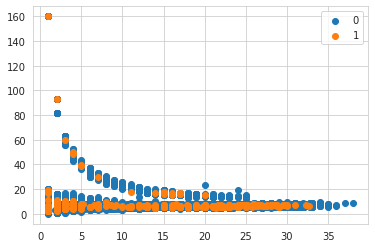

In [146]:
# borderline-SMOTE for imbalanced dataset
### Creas muestas que se encuentra dentro de la frontera de la clase minoritaria para evitar datos mal clasificados
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import BorderlineSMOTE
from matplotlib import pyplot
from numpy import where
# define dataset
# summarize class distribution
counter = Counter(y_train)
print(counter)
# transform the dataset
oversample = BorderlineSMOTE()
x_train_, y_train_ = oversample.fit_resample(x_train, y_train)
# summarize the new class distribution
counter = Counter(y_train_)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(x_train_[row_ix, 0], x_train_[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [145]:
# ### crear mas muestras en regiones que se encuentra muy alejados de la linea de frontera
# from collections import Counter
# from sklearn.datasets import make_classification
# from imblearn.over_sampling import SVMSMOTE
# from matplotlib import pyplot
# from numpy import where

# # summarize class distribution
# counter = Counter(y_train)
# print(counter)
# # transform the dataset
# oversample = SVMSMOTE()
# x_train_, y_train_ = oversample.fit_resample(x_train, y_train)
# # summarize the new class distribution
# counter = Counter(y_train_)
# print(counter)
# # scatter plot of examples by class label
# for label, _ in counter.items():
# 	row_ix = where(y == label)[0]
# 	pyplot.scatter(x_train_[row_ix, 0], x_train_[row_ix, 1], label=str(label))
# pyplot.legend()
# pyplot.show()

In [147]:
import lightgbm as lgb
train_data=lgb.Dataset(x_train_,label = y_train_)
### definir los parámetros del modelo
param = {'num_leaves':50,'objective':'binary','max_depth':9,'learning_rate':0.01,'max_bin':200} ## 100 ###6, ##200
param['metric'] =['auc','binary_logloss']
num_round=500 ##1000
### entrenar el modelo Ligh GBM
clf=lgb.train(param,train_data,num_round)

In [148]:
# Find optimal probability threshold
pred = clf.predict(x_test)
# pred = clf.predict_proba(x_test)[:,-1]
pred

array([0.01039857, 0.00436756, 0.00435469, ..., 0.01712968, 0.00435469,
       0.00654462])

In [149]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, pred)

0.9059296355867491

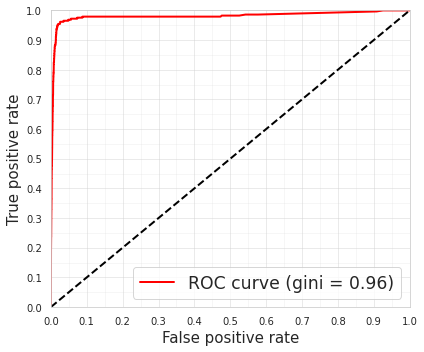

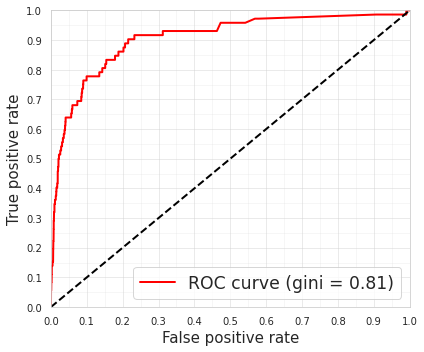

In [150]:
##ROC en el train
pred_train=clf.predict(x_train)
plot_roc_curve(y_train,pred_train,width=6,height=5)
##ROC en el test
pred_test=clf.predict(x_test)
plot_roc_curve(y_test,pred_test,width=6,height=5)

In [151]:
from sklearn.metrics import classification_report
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6839
           1       0.25      0.21      0.23        72

    accuracy                           0.99      6911
   macro avg       0.62      0.60      0.61      6911
weighted avg       0.98      0.99      0.98      6911



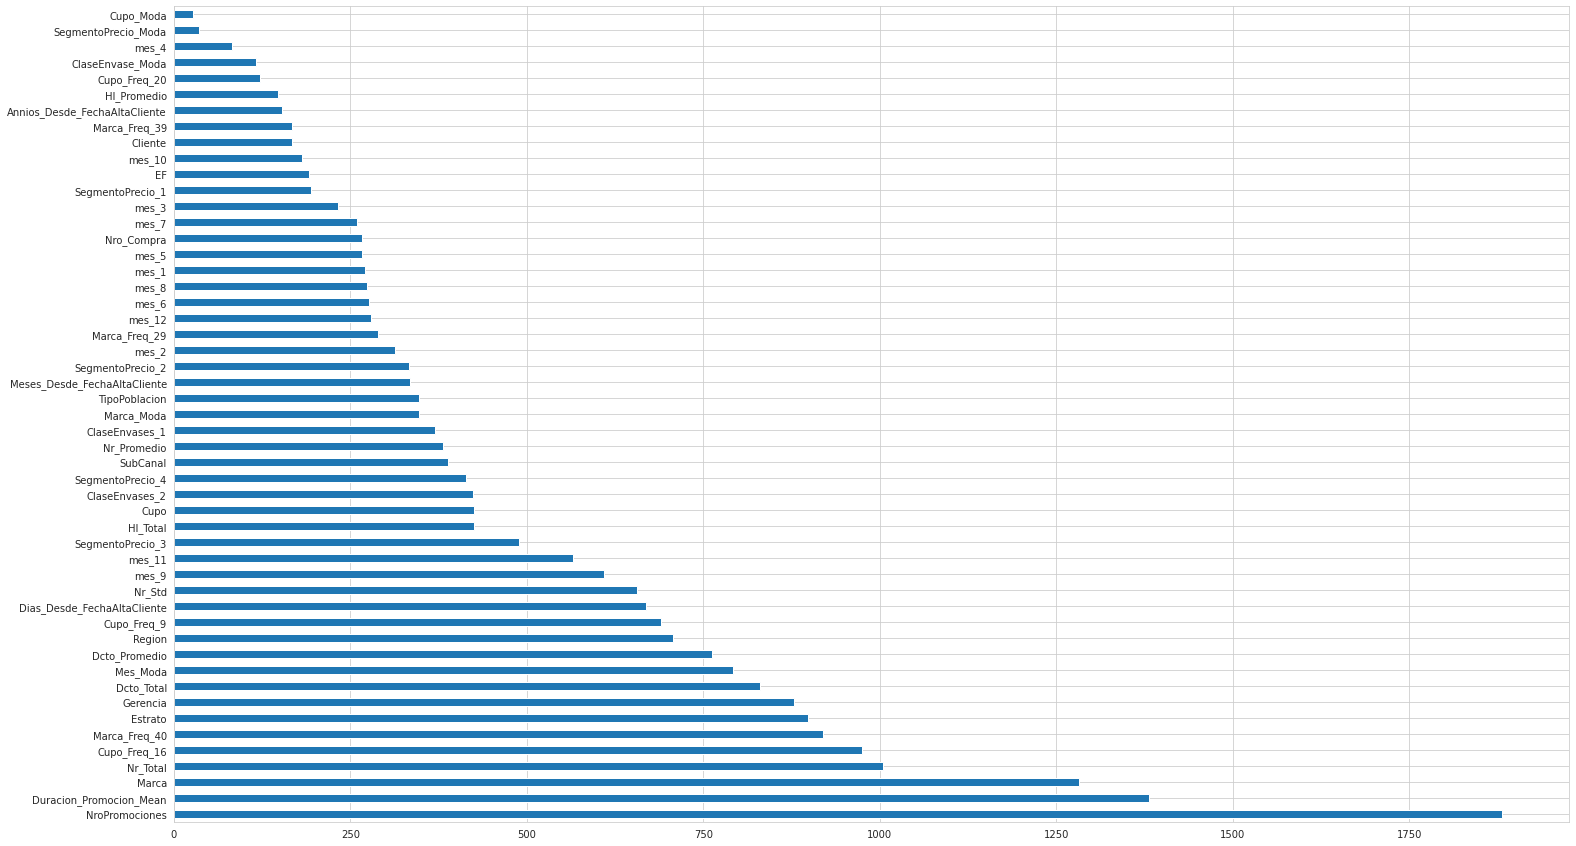

In [152]:
feat_importances = pd.Series(clf.feature_importance(), index=x.columns)
# feat_importances = pd.Series(clf.feature_importances_, index=x.columns)
feat_importances.nlargest(52).plot(kind='barh', figsize=(25, 15))

In [153]:
pred_ = clf.predict(x.loc[df_test.index])
# pred_ = clf.predict_proba(x.loc[df_test.index])[:,-1]
# pred_=xgBoost.predict(xgb.DMatrix(x.loc[df_test.index],label=y.loc[df_test.index]))
# pred_[pred_<0] = 0
# pred_ = rf.predict_proba(x.loc[df_test.index])[:,-1]
# pred_= clf.predict(x.loc[df_test.index])*0.9 + xgBoost.predict(xgb.DMatrix(x.loc[df_test.index],label=y.loc[df_test.index]))*0.1
# pred_[pred_<0] = 0
# pred_= clf.predict(x.loc[df_test.index])*0.7 + rf.predict_proba(x.loc[df_test.index])[:,-1]*0.20 + xgBoost.predict(xgb.DMatrix(x.loc[df_test.index],label=y.loc[df_test.index]))*0.10
# pred_[pred_<0] = 0
df_test['Ejecuto_Promo'] = pred_
df_test

,Cliente,Marca,Cupo,Ejecuto_Promo
Cliente_Marca_Cupo,,,,
104016,10,40,16,0.004468
17299,17,29,9,0.007884
37299,37,29,9,0.004361
46299,46,29,9,0.008546
48299,48,29,9,0.004355
...,...,...,...,...
150534016,15053,40,16,0.040909
150544016,15054,40,16,0.032948
150564016,15056,40,16,0.045350


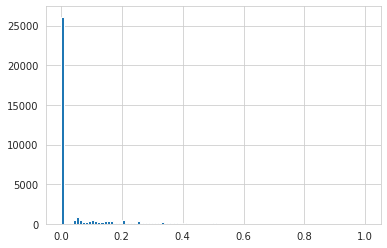

In [154]:
df_intermediate['NroPromocionesRatio'].hist(bins=100)

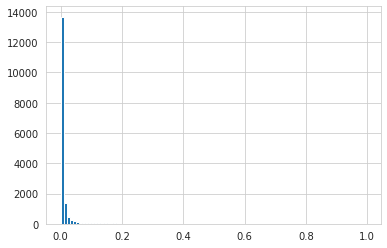

In [155]:
df_test['Ejecuto_Promo'].hist(bins=100)

In [156]:
df_test.to_csv('../results/df_pred_v121.csv', sep=',', encoding='utf 8', index = False)

In [144]:
df_test_ = pd.read_csv('../results/df_pred_v120.csv', sep=',')
df_test_

,Cliente,Marca,Cupo,Ejecuto_Promo
0,10,40,16,0.003177
1,17,29,9,0.007818
2,37,29,9,0.002867
3,46,29,9,0.005611
4,48,29,9,0.002926
...,...,...,...,...
16865,15053,40,16,0.026743
16866,15054,40,16,0.028750
16867,15056,40,16,0.023782
16868,15057,29,9,0.003066
